In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, BatchNormalization, Dropout, LeakyReLU, DepthwiseConv2D, Flatten
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

from tqdm import tqdm, tqdm_notebook

import numpy as np
import pandas as pd
import cv2 as cv
import seaborn as sns
import matplotlib.pyplot as plt

import os

Using TensorFlow backend.


In [2]:
os.listdir('../input')

['train', 'test', 'train.csv', 'sample_submission.csv']

In [3]:
train_data = pd.read_csv('../input/train.csv')

In [4]:
train_data.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [5]:
def create_model():
    model = Sequential()
        
    model.add(Conv2D(3, kernel_size = 3, activation = 'relu', input_shape = (32, 32, 3)))
    
    model.add(Conv2D(filters = 16, kernel_size = 3, activation = 'relu'))
    model.add(Conv2D(filters = 16, kernel_size = 3, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'Same', use_bias = True))
    model.add(Conv2D(filters = 32, kernel_size = 1, activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(DepthwiseConv2D(kernel_size = 3, strides = 2, padding = 'Same', use_bias = True))
    model.add(Conv2D(filters = 128, kernel_size = 1, activation = 'relu'))
    model.add(Conv2D(filters = 256, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'Same', use_bias = True))
    model.add(Conv2D(filters = 256, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 512, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(DepthwiseConv2D(kernel_size = 3, strides = 2, padding = 'Same', use_bias = True))
    model.add(Conv2D(filters = 512, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 1024, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'Same', use_bias = True))
    model.add(Conv2D(filters = 1024, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 2048, kernel_size = 1, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    #model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    
    model.add(Dense(470, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation = 'tanh'))

    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = ['accuracy'])
    
    return model

In [6]:
def plot_training_curves(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Losses')
    plt.legend()
    plt.figure()
    
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Accuracies')
    plt.legend()
    plt.figure()
    
    plt.show()
    

In [7]:
file_path = 'weights-aerial-cactus.h5'

callbacks = [
        ModelCheckpoint(file_path, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max'),
        ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, mode = 'min', min_lr = 0.00001),
        EarlyStopping(monitor = 'val_loss', min_delta = 1e-10, patience = 15, verbose = 1, restore_best_weights = True)
        ]

training_path = '../input/train/train/'
test_path = '../input/test/test/'

In [8]:
images_train = []
labels_train = []

images = train_data['id'].values
for image_id in tqdm_notebook(images):
    
    image = np.array(cv.imread(training_path + image_id))
    label = train_data[train_data['id'] == image_id]['has_cactus'].values[0]
    
    images_train.append(image)
    labels_train.append(label)
    
    images_train.append(np.flip(image))
    labels_train.append(label)
    
    images_train.append(np.flipud(image))
    labels_train.append(label)
    
    images_train.append(np.fliplr(image))
    labels_train.append(label)
    
    
images_train = np.asarray(images_train)
images_train = images_train.astype('float32')
images_train /= 255.

labels_train = np.asarray(labels_train)

In [9]:
x_tr = images_train
y_tr = labels_train

images_train = x_tr
labels_train = y_tr

In [10]:
test_images_names = []

for filename in os.listdir(test_path):
    test_images_names.append(filename)
    
test_images_names.sort()

images_test = []

for image_id in tqdm_notebook(test_images_names):
    images_test.append(np.array(cv.imread(test_path + image_id)))
    
images_test = np.asarray(images_test)
images_test = images_test.astype('float32')
images_test /= 255

In [11]:
x_train, x_test, y_train, y_test = train_test_split(images_train, labels_train, test_size = 0.2, stratify = labels_train)

In [12]:
model = create_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
history = model.fit(x_train, 
            y_train, 
            batch_size = 128, 
            epochs = 80, 
            validation_data = (x_test, y_test),
            verbose = 1,
            callbacks = callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 56000 samples, validate on 14000 samples
Epoch 1/80
56000/56000 [==============================] - 48s 862us/step - loss: 0.0491 - acc: 0.9366 - val_loss: 0.0809 - val_acc: 0.9145

Epoch 00001: val_acc improved from -inf to 0.91450, saving model to weights-aerial-cactus.h5
Epoch 2/80
56000/56000 [==============================] - 42s 743us/step - loss: 0.0133 - acc: 0.9832 - val_loss: 0.0453 - val_acc: 0.9516

Epoch 00002: val_acc improved from 0.91450 to 0.95164, saving model to weights-aerial-cactus.h5
Epoch 3/80
56000/56000 [==============================] - 42s 742us/step - loss: 0.0092 - acc: 0.9886 - val_loss: 0.0244 - val_acc: 0.9714

Epoch 00003: val_acc improved from 0.95164 to 0.97143, saving model to weights-aerial-cactus.h5
Epoch 4/80
56000/56000 [==============================] - 42s 742us/step - loss: 0.0069 - acc: 0.9916 - val_loss: 0.0149 - val_acc: 0.9834

Epoch 00004: val_acc improved from 0.97143 to 0.98336, sa

In [14]:
model.load_weights(file_path)

In [15]:
predictions = model.predict(images_test, verbose = 1)

4000/4000 [==============================] - 1s 310us/step


In [16]:
predictions

array([[0.9989281 ],
       [0.99892426],
       [0.00151393],
       ...,
       [0.99892485],
       [0.99892664],
       [0.99892753]], dtype=float32)

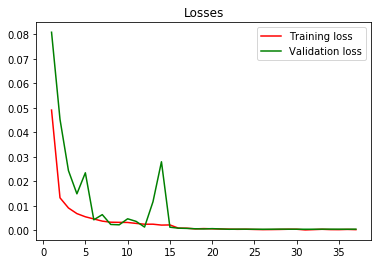

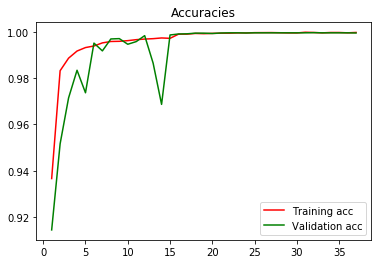

<Figure size 432x288 with 0 Axes>

In [17]:
plot_training_curves(history)

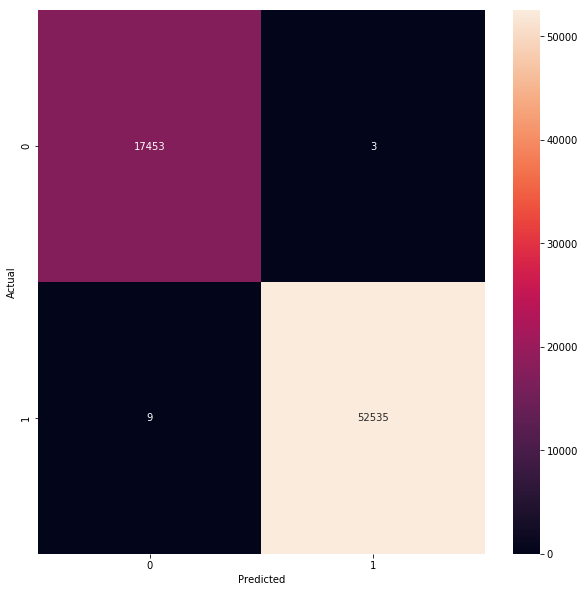

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17456
           1       1.00      1.00      1.00     52544

   micro avg       1.00      1.00      1.00     70000
   macro avg       1.00      1.00      1.00     70000
weighted avg       1.00      1.00      1.00     70000



 AUC: 1.0000


In [18]:
y_pred_probability = model.predict_proba(x_tr)

y_pred = model.predict_classes(x_tr)
conf_matrix = confusion_matrix(y_tr, y_pred)
fig, ax = plt.subplots(figsize = (10, 10))

sns.heatmap(conf_matrix, annot = True, fmt = 'd', xticklabels = ['0', '1'], yticklabels = ['0', '1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(classification_report(y_tr, y_pred, target_names = ['0','1']))
print("\n\n AUC: {:<0.4f}".format(roc_auc_score(y_tr, y_pred_probability)))

In [19]:
test_df = pd.read_csv('../input/sample_submission.csv')
X_test = []
images_test = test_df['id'].values

for img_id in tqdm_notebook(images_test):
    X_test.append(cv.imread(test_path + img_id))
    
X_test = np.asarray(X_test)
X_test = X_test.astype('float32')
X_test /= 255

y_test_pred = model.predict_proba(X_test)

test_df['has_cactus'] = y_test_pred
test_df.to_csv('aerial-cactus-submission.csv', index = False)